In [2]:
%matplotlib inline
import sys
sys.path.append('/home/igr/src/model/nengo_maze_env')
from functools import partial
import nengo
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nengo_dl
from prf_net import PRF
from tqdm import tqdm
import scipy.interpolate
from scipy.interpolate import Rbf, PchipInterpolator, Akima1DInterpolator
from nengo_extras.plot_spikes import (
    cluster, merge, plot_spikes, preprocess_spikes, sample_by_variance, sample_by_activity)
from nengo_extras.neurons import (
    rates_kernel, rates_isi, spikes2events )

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module '_yaml' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
def contiguous_ranges(input, return_indices=False):
    """Finds contiguous regions of the array "input". Returns
    a list of ranges with the start and end index of each region. Code based on:
    https://stackoverflow.com/questions/4494404/find-large-number-of-consecutive-values-fulfilling-condition-in-a-numpy-array/4495197
    """

    # Find the indices of changes in "condition"
    d = np.diff(input)
    nz, = d.nonzero() 

    print(nz)
    # We need to start things after the change in "condition". Therefore, 
    # we'll shift the ranges by 1 to the right.
    nz += 1
    nz = np.concatenate([nz, [input.size]])
    
    ranges = np.vstack([ [nz[ri], nz[ri+1]] for ri in range(nz.size-1) ])
    ranges = np.vstack([[0, nz[0]], ranges])

    # Reshape the result into two columns
    ranges.shape = (-1,2)

    if return_indices:
        result = ( np.arange(*r) for r in ranges )
    else:
        result = ranges

    return result

In [4]:
#download mnist dataset
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.mnist.load_data()
print(train_data.shape)

#flatten images
train_data = train_data.reshape((train_data.shape[0], -1))
test_data = test_data.reshape((test_data.shape[0], -1))
print(np.max(test_data))

print(test_labels.shape)

(60000, 28, 28)
255
(10000,)


In [5]:
with nengo.Network(seed = 0) as auto_net:
    auto_net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([40])
    auto_net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    auto_net.config[nengo.Connection].synapse = None # this disables synaptic filtering

    # n_type = nengo.PoissonSpiking(nengo.RectifiedLinear())
    # n_type = nengo.RectifiedLinear()
    n_type = nengo.SpikingRectifiedLinear() 

    n_in = 784
    inter_dim = 128

    inp_node = nengo.Node(np.zeros(n_in))

    # first layer
    enc1 = nengo.Ensemble(inter_dim, 1, neuron_type = n_type)
    nengo.Connection(inp_node, enc1.neurons, transform=nengo_dl.dists.Glorot())

    # second layer
    enc2 = nengo.Ensemble(inter_dim, 1, neuron_type = n_type)
    nengo.Connection(enc1.neurons, enc2.neurons, transform=nengo_dl.dists.Glorot())

    # output layer
    outp = nengo.Ensemble(n_in, 1, neuron_type=n_type)
    nengo.Connection(enc2.neurons, outp.neurons, transform=nengo_dl.dists.Glorot())

    # probes
    p_c = nengo.Probe(outp.neurons)
    p_c_filt = nengo.Probe(outp.neurons, synapse=0.01, label="out_p_filt")
    p_enc1 = nengo.Probe(enc1.neurons, synapse=None, label="enc1_p")
    p_enc2 = nengo.Probe(enc2.neurons, synapse=None, label="enc2_p")
    
    # from mnist example
    # out_p = nengo.Probe(outp, label="out_p")
    # out_p_filt = nengo.Probe(outp, synapse=0.1, label="out_p_filt")



In [37]:
minibatch_size = 50

with nengo_dl.Simulator(network=auto_net, minibatch_size=minibatch_size) as sim:
  sim.predict(np.ones((minibatch_size, 1, n_in)));

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
|##############Constructing graph: build stage (22%)             | ETA: 0:00:00

/home/igr/.local/lib/python3.6/site-packages/nengo_dl/simulator.py:461: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  "No GPU support detected. See "


Construction finished in 0:00:00                                               
|############Constructing graph: build stage (100%)############| ETA:  00:00:00

/home/igr/.local/lib/python3.6/site-packages/nengo_dl/simulator.py:1026: UserWarning: Running for one timestep, but the network contains synaptic filters (which will introduce at least a one-timestep delay); did you mean to set synapse=None?
  "Running for one timestep, but the network contains "


In [38]:
# changing the model to more closely match how tensorflow works

for ens in auto_net.all_ensembles:
  ens.gain = nengo.dists.Choice([1]) # set all gains to 1
  ens.bias = nengo.dists.Choice([0]) # set all biases to 0 

# disables synaptic filtering.. eventually we want to use it though
for conn in auto_net.all_connections:
  conn.synapse = None 

In [39]:
# reshaping the data again for use in simulation, since with spiking networks simulations are temporal
# shape: (batch_size, n_steps, n)

train_data = train_data[:, None, :]
print(np.max(train_data))

# # when testing our network with spiking neurons we will need to run it 
# # over time, so we repeat the input/target data for a number of 
# # timesteps.

n_steps = 100
test_data = np.tile(test_data[:, None, :], (1, n_steps, 1))


255


In [40]:
test_labels = np.tile(test_labels[:, None], (1, n_steps))


In [41]:
with nengo_dl.Simulator(auto_net, minibatch_size=minibatch_size) as sim:
  sim.compile(optimizer = tf.optimizers.RMSprop(1e-3), 
              loss = {p_c: tf.losses.mse, # mean squared error as loss function
                      #p_c: tf.losses.kullback_leibler_divergence, 
                      p_c_filt: None}
             ) 

  # run training loop. If using spiking neurons, this converts the model to a rate based approximation and then does training
  sim.fit(train_data, train_data, epochs = 10)
  sim.freeze_params(auto_net)

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
|##############Constructing graph: build stage (22%)             | ETA: 0:00:00

/home/igr/.local/lib/python3.6/site-packages/nengo/builder/ensemble.py:115: NengoWarning: Specifying the gains and biases for <Ensemble (unlabeled) at 0x7f50603bde10> imposes a set of maximum firing rates and intercepts. Further specifying either max_rates or intercepts has no effect.
  "either max_rates or intercepts has no effect." % ens
/home/igr/.local/lib/python3.6/site-packages/nengo/builder/ensemble.py:115: NengoWarning: Specifying the gains and biases for <Ensemble (unlabeled) at 0x7f50603bdf60> imposes a set of maximum firing rates and intercepts. Further specifying either max_rates or intercepts has no effect.
  "either max_rates or intercepts has no effect." % ens
/home/igr/.local/lib/python3.6/site-packages/nengo/builder/ensemble.py:115: NengoWarning: Specifying the gains and biases for <Ensemble (unlabeled) at 0x7f50603c0160> imposes a set of maximum firing rates and intercepts. Further specifying either max_rates or intercepts has no effect.
  "either max_rates or interce

Construction finished in 0:00:00                                               
Epoch 1/10
|##############Constructing graph: build stage (55%)             | ETA: 0:00:00

/home/igr/.local/lib/python3.6/site-packages/nengo_dl/simulator.py:1773: UserWarning: Number of elements (1) in ['ndarray'] does not match number of Probes (4); consider using an explicit input dictionary in this case, so that the assignment of data to objects is unambiguous.
  len(objects),


1200/1200 [==============================] - 15s 13ms/step - loss: 1409.6179 - probe_loss: 1409.6179
Epoch 2/10
1200/1200 [==============================] - 15s 13ms/step - loss: 945.0902 - probe_loss: 945.0902
Epoch 3/10
1200/1200 [==============================] - 15s 13ms/step - loss: 859.1498 - probe_loss: 859.1498
Epoch 4/10
1200/1200 [==============================] - 15s 13ms/step - loss: 819.3806 - probe_loss: 819.3806
Epoch 5/10
1200/1200 [==============================] - 15s 13ms/step - loss: 792.6276 - probe_loss: 792.6276
Epoch 6/10
1200/1200 [==============================] - 15s 13ms/step - loss: 772.7725 - probe_loss: 772.7725
Epoch 7/10
1200/1200 [==============================] - 15s 13ms/step - loss: 758.3553 - probe_loss: 758.3553
Epoch 8/10
1200/1200 [==============================] - 15s 13ms/step - loss: 738.1925 - probe_loss: 738.1925
Epoch 9/10
1200/1200 [==============================] - 15s 13ms/step - loss: 713.2304 - probe_loss: 713.2304
Epoch 10/10
1200/12

In [42]:
for conn in auto_net.all_connections:
    conn.synapse = 0.005

with nengo_dl.Simulator(auto_net, minibatch_size=minibatch_size) as sim:


  sim.compile(optimizer = tf.optimizers.RMSprop(1e-3), 
              loss = {p_c: tf.losses.mse, # mean squared error as loss function
                      #p_c: tf.losses.kullback_leibler_divergence, 
                      p_c_filt: None}
             )
  # evaluate performance on test set
  print("Test error: ", sim.evaluate(test_data, {p_c: test_data}))

  # display example output
  output = sim.predict(test_data[:minibatch_size]) # runs sim.predict on the first minibatch of the data 
 

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
200/200 [==============================] - 220s 1s/step - loss: 20772.9355 - probe_loss: 20772.9355
Test error:  OrderedDict([('loss', 20772.935546875), ('probe_loss', 20772.935546875)])


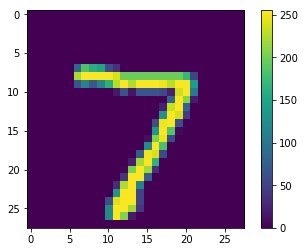

In [43]:
plt.figure()
plt.imshow(test_data[0, n_steps-1].reshape((28,28)), interpolation="nearest", aspect="equal")
plt.colorbar();

(50, 100, 784)


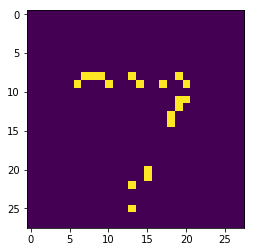

In [44]:
# plt.figure()
plt.imshow(output[p_c][0, n_steps-1].reshape((28, 28)))
print(output[p_c].shape)

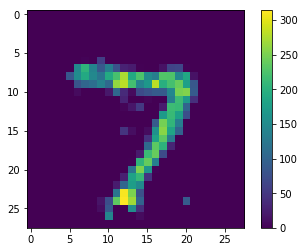

In [45]:
plt.figure()
plt.imshow(output[p_c_filt][0, n_steps-1].reshape((28, 28)))
plt.colorbar()


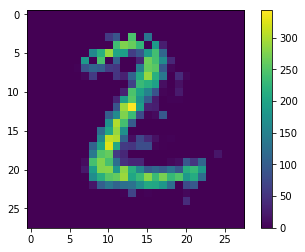

In [46]:
plt.figure()
plt.imshow(output[p_c_filt][1, n_steps-1].reshape((28, 28)))
plt.colorbar();


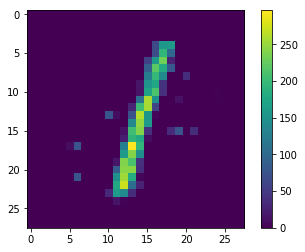

In [47]:
plt.figure()
plt.imshow(output[p_c_filt][2, n_steps-1].reshape((28, 28)))
plt.colorbar()


(50, 100, 128)
(5000, 128)
(5000,)
67696
(5000, 128)


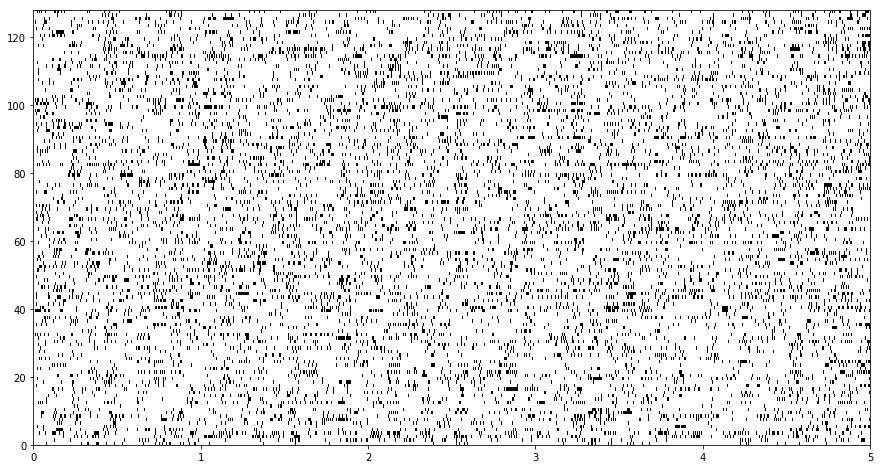

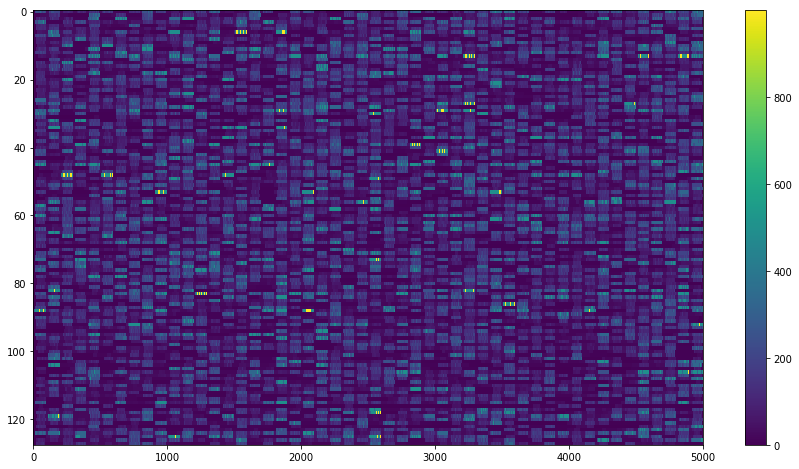

In [48]:
dt = 0.001
print(output[p_enc2].shape)

enc2_spikes = output[p_enc2].reshape((-1,inter_dim))
trange = np.linspace(0, enc2_spikes.shape[0]*dt, enc2_spikes.shape[0])
print(enc2_spikes.shape)
print(trange.shape)
plt.figure(figsize=(15,8))
plot_spikes(trange, enc2_spikes);

enc2_output = np.asarray(enc2_spikes * dt, dtype=np.uint8)

print(np.sum(enc2_output))
plt.figure(figsize=(15,8))
enc2_rates = rates_isi(trange, enc2_spikes)
print(enc2_rates.shape)
plt.imshow(enc2_rates.T, interpolation="nearest", aspect="auto")
plt.colorbar();


In [120]:

n_trials = 3

encoded_inputs = enc2_output*2
print(encoded_inputs.shape)
n_test = encoded_inputs.shape[0]
input_time_array = np.linspace(0, n_test*n_trials*dt, encoded_inputs.shape[0]*n_trials)
input_matrix = np.tile(encoded_inputs, (n_trials, 1))
print(input_matrix.shape)
np.save("srf_nengo_autoencoder_input_matrix_mnist", np.asarray(input_matrix, dtype=np.float32))



(5000, 128)
(15000, 128)


In [133]:
sorted_test_labels = np.sort(test_labels[:minibatch_size].flat, kind='stable')
print(np.unique(sorted_test_labels, return_counts=True))
sorted_test_label_idxs = np.argsort(test_labels[:minibatch_size].flat, kind='stable')
print(sorted_test_label_idxs)
input_labels = np.tile(sorted_test_label_idxs, (n_trials,))
for i in range(n_trials-1):
    input_labels[((i+1)*n_test):] += n_test



(array([0, 1, 2, 3, 4, 5, 6, 7, 9], dtype=uint8), array([500, 900, 500, 400, 900, 400, 300, 600, 500]))
[ 300  301  302 ... 2097 2098 2099]


In [1]:
target_interval = range(*test_label_ranges[0])

sample = input_labels[:n_test][target_interval]  
sample_ends = sample[range(n_steps-1, sample.shape[0], n_steps)]
plt.axis('off')
for p in sample_ends:
    plt.figure()
    plt.imshow(output[p_c_filt].reshape((-1, 784))[p].reshape((28,28)))
    plt.colorbar()

    

NameError: name 'test_label_ranges' is not defined

(15000, 128)


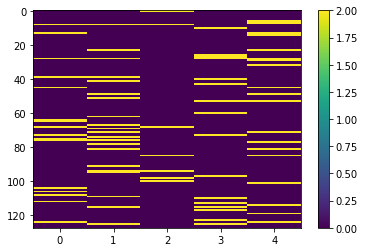

In [145]:
print(input_matrix.shape)
plt.figure()
plt.imshow(input_matrix[sample_ends,:].T, aspect='auto')
plt.colorbar();


In [50]:
input_matrix = np.load("srf_nengo_autoencoder_input_matrix_mnist.npy")
print(input_matrix.shape)

(15000, 128)


In [51]:
def array_input(input_matrix, dt, t, *args):
    i = int(t/dt)
    if i >= input_matrix.shape[0]:
        i = -1
    return input_matrix[i,:]

In [69]:
N_Outputs = 100
N_Exc = input_matrix.shape[1]
N_Inh = int(N_Exc/4)

dt = 0.001
srf_seed = 19
t_end = input_matrix.shape[0] * dt
srf_network = PRF(exc_input_func = partial(array_input, input_matrix, dt),
                  connect_exc_inh_input = True,
                  n_excitatory = N_Exc,
                  n_inhibitory = N_Inh,
                  n_outputs = N_Outputs,
                  isp_target_rate = 2.0,
                  
                  
                  w_initial_E = 0.003,
                  w_initial_EI = 0.008,
                  w_EI_Ext = 0.0086,
                  w_initial_I = -0.05,
                  p_E = 0.163,
                  p_EE = 0.35,
                  p_EI_Ext = 0.172,
                  
                  tau_E = 0.049,
                  tau_I = 0.098,
                  learning_rate_I=0.01,
                  learning_rate_E=0.055,
                  
#                  w_initial_E = 0.003,
#                  w_initial_EI = 0.008,
#                  w_EI_Ext = 0.0086,
#                  w_initial_I = -0.05,
#                  p_E = 0.163,
#                  p_EE = 0.35,
#                  p_EI_Ext = 0.172,
                  
#                  tau_E = 0.049,
#                  tau_I = 0.098,
#                  learning_rate_I=0.001,
#                  learning_rate_E=0.055,

                  p_EI = 0.4,
                  tau_input = 0.1,
                  label="Spatial receptive field network",
                  seed=srf_seed)



In [70]:
#srf_network.out_ens_config[nengo.Ensemble].update({'neuron_type': nengo.Izhikevich(reset_voltage=-55, reset_recovery=4)})
srf_network.output.neuron_type

LIF()

In [71]:

with srf_network:
    p_output_spikes = nengo.Probe(srf_network.output.neurons, 'spikes', synapse=None)
    p_exc_rates = nengo.Probe(srf_network.exc.neurons, 'rates')
    p_inh_rates = nengo.Probe(srf_network.inh.neurons, 'rates')
#    p_inh_weights = nengo.Probe(srf_network.conn_I, 'weights')
#    p_exc_weights = nengo.Probe(srf_network.conn_E, 'weights')
#    if srf_network.conn_EE is not None:
#        p_rec_weights = nengo.Probe(srf_network.conn_EE, 'weights')
        
with nengo.Simulator(srf_network, optimize=True) as sim:
    sim.run(np.max(t_end))
    


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [72]:
output_spikes = sim.data[p_output_spikes]
np.save("srf_output_spikes", np.asarray(output_spikes, dtype=np.float32))
np.save("srf_time_range", np.asarray(sim.trange(), dtype=np.float32))

exc_rates = sim.data[p_exc_rates]
inh_rates = sim.data[p_inh_rates] 
#exc_weights = sim.data[p_exc_weights]
#inh_weights = sim.data[p_inh_weights] 


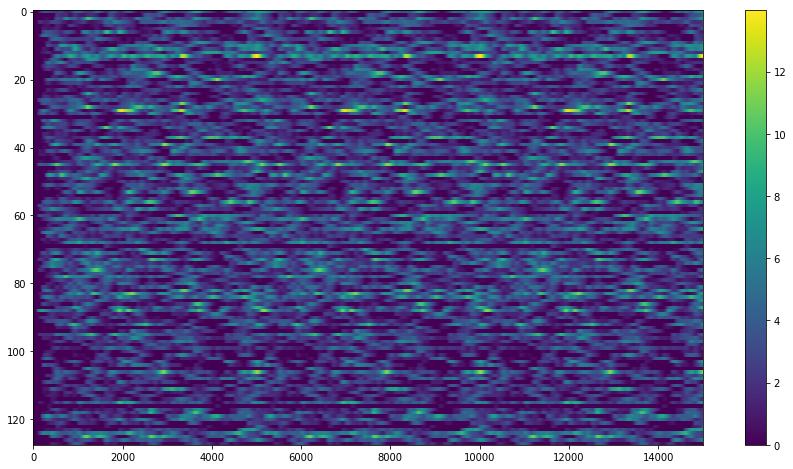

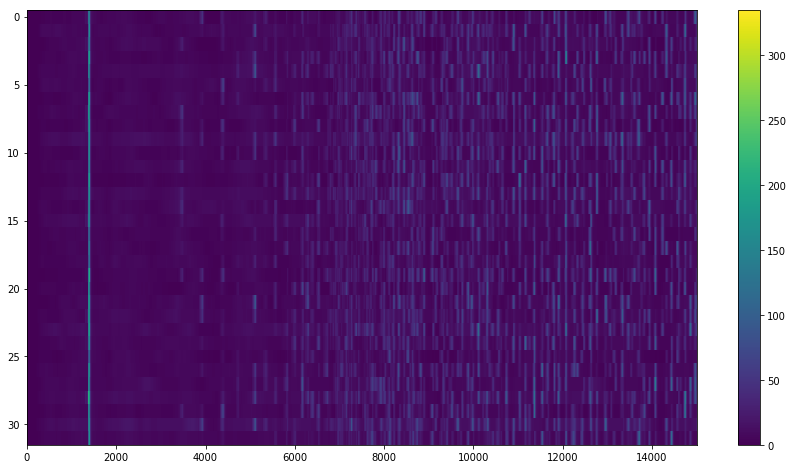

In [73]:
plt.figure(figsize=(15,8))
plt.imshow(exc_rates.T, interpolation="nearest", aspect="auto")
plt.colorbar();

plt.figure(figsize=(15,8))
plt.imshow(inh_rates.T, interpolation="nearest", aspect="auto")
plt.colorbar();


1.0876244308343959


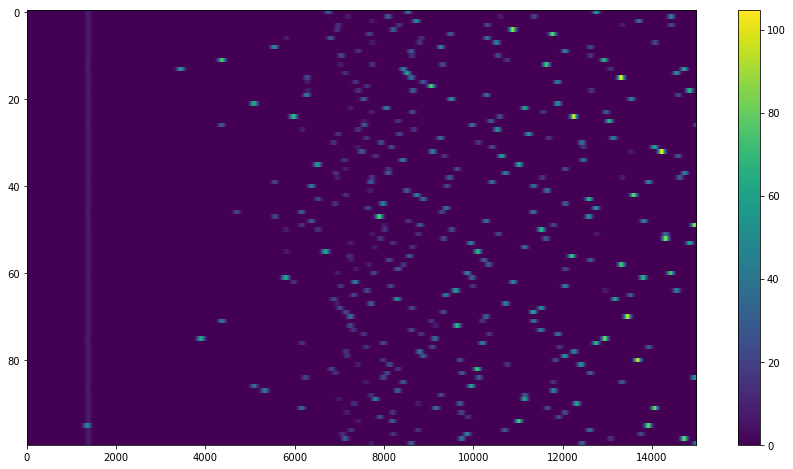

In [74]:
output_rates = rates_kernel(sim.trange(), output_spikes, tau=0.1)
plt.figure(figsize=(15,8))
plt.imshow(output_rates.T, interpolation="nearest", aspect="auto")
plt.colorbar();
print(np.mean(output_rates))


1.0876244308343959


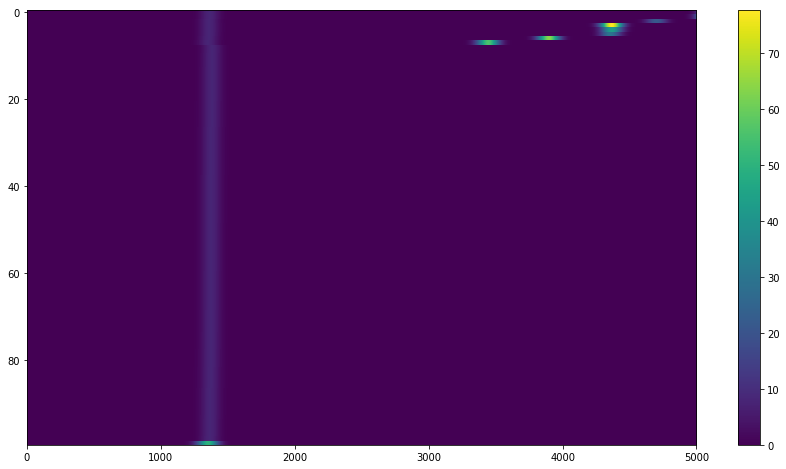

In [156]:
output_rates = rates_kernel(sim.trange(), output_spikes, tau=0.1)
plt.figure(figsize=(15,8))
sorted_idxs = np.argsort(-np.argmax(output_rates[:5000].T, axis=1))
plt.imshow(output_rates[:5000,sorted_idxs].T, interpolation="nearest", aspect="auto")
plt.colorbar();
print(np.mean(output_rates))


1.0876244308343959


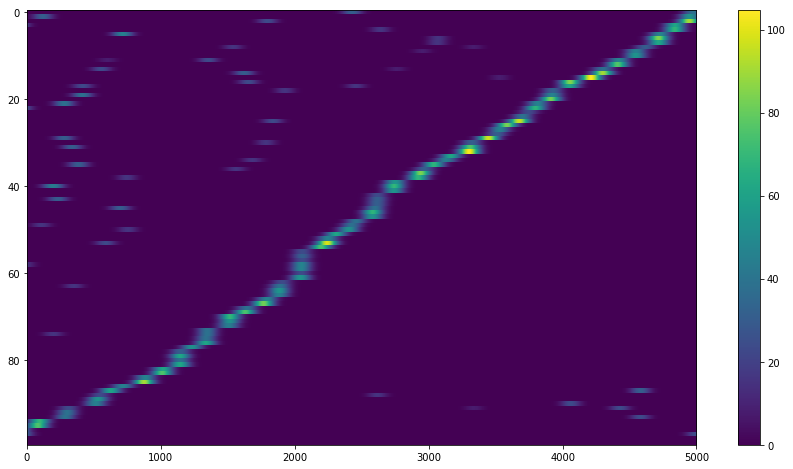

In [155]:
output_rates = rates_kernel(sim.trange(), output_spikes, tau=0.1)
plt.figure(figsize=(15,8))
sorted_idxs = np.argsort(-np.argmax(output_rates[10000:].T, axis=1))
plt.imshow(output_rates[10000:,sorted_idxs].T, interpolation="nearest", aspect="auto")
plt.colorbar();
print(np.mean(output_rates))


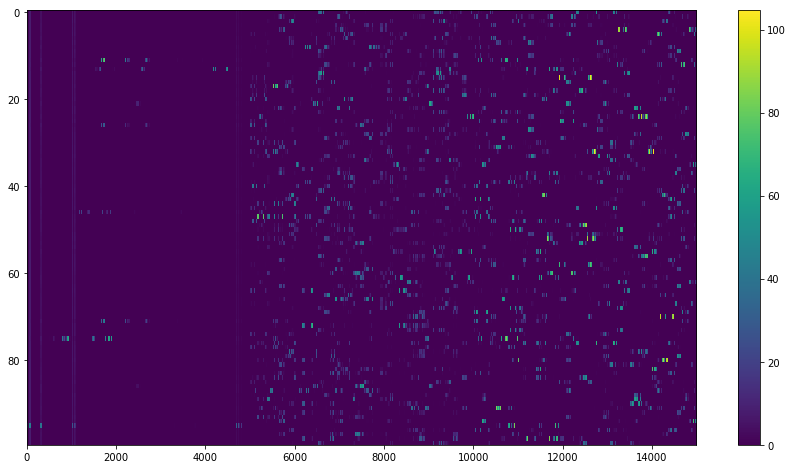

In [75]:

plt.figure(figsize=(15,8))
plt.imshow(output_rates[input_labels,:].T, interpolation="nearest", aspect="auto")
plt.colorbar();


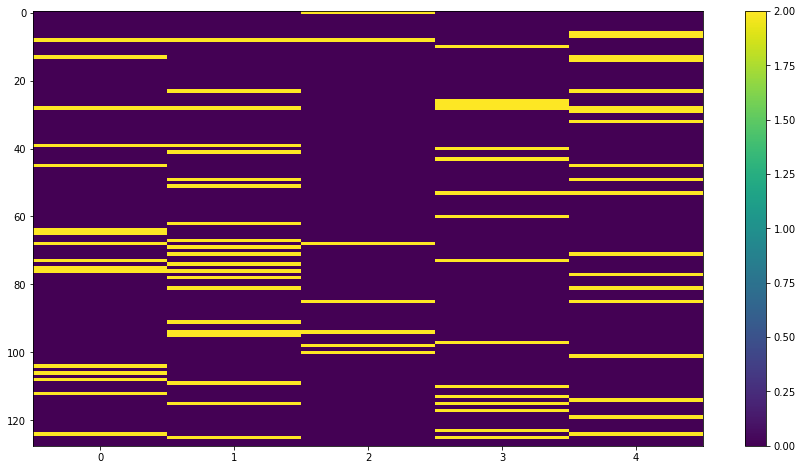

In [146]:
target_interval = range(*test_label_ranges[0])

sample = input_labels[:n_test][target_interval]  
sample_ends = sample[range(n_steps-1, sample.shape[0], n_steps)]

plt.figure(figsize=(15,8))
plt.imshow(input_matrix[sample_ends,:].T, interpolation="nearest", aspect="auto")
plt.colorbar();


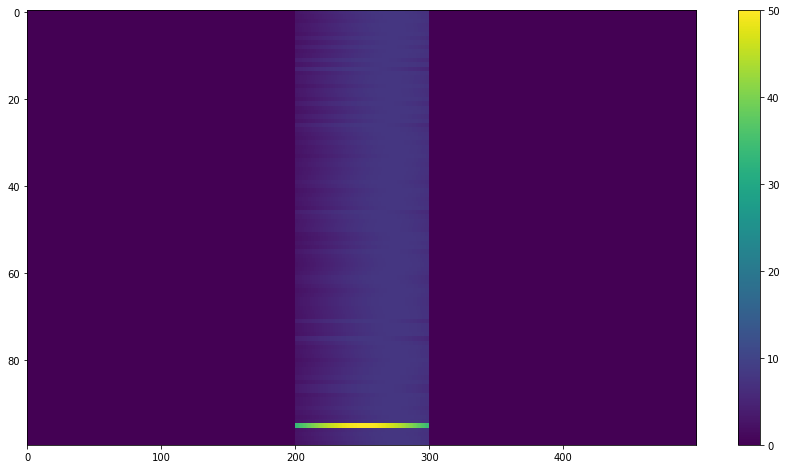

In [159]:
plt.figure(figsize=(15,8))
plt.imshow(output_rates[sample,:].T, interpolation="nearest", aspect="auto")
plt.colorbar();


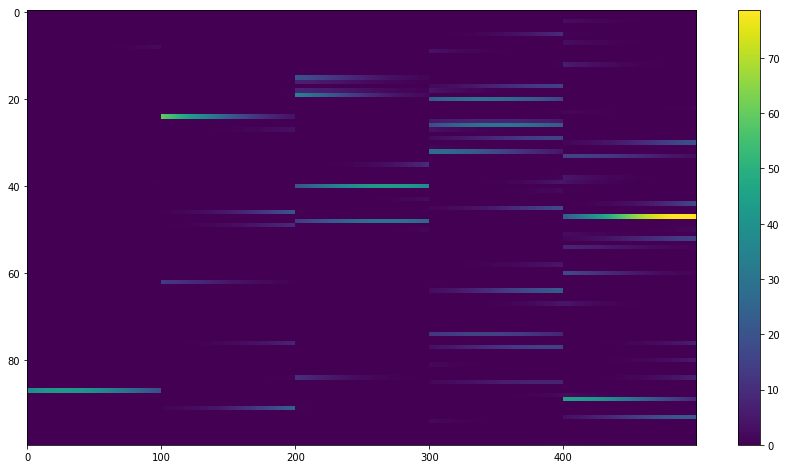

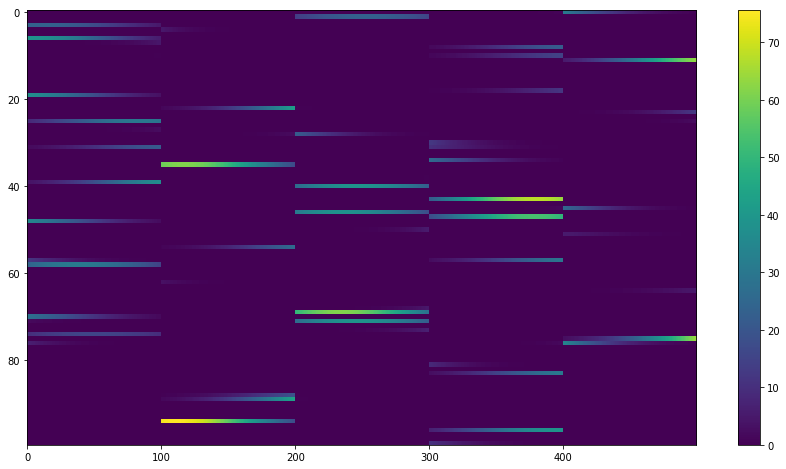

In [162]:

plt.figure(figsize=(15,8))
plt.imshow(output_rates[sample+5000,:].T, interpolation="nearest", aspect="auto")
plt.colorbar();
plt.figure(figsize=(15,8))
plt.imshow(output_rates[sample+10000,:].T, interpolation="nearest", aspect="auto")
plt.colorbar();

